C:\Users\Riyaz\AppData\Local\Temp\ipykernel_2572\1089266920.py:23: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: x.strip() if isinstance(x, str) else x)


Dataset shape: (4269, 11)
Class distribution:
 loan_status
1    2656
0    1613
Name: count, dtype: int64

Cross-Validation Results:
Model A - Accuracy: 0.9792, F1: 0.9833
Model B - Accuracy: 0.9806, F1: 0.9845
T-test Accuracy Difference: t=-1.5000, p=0.2080


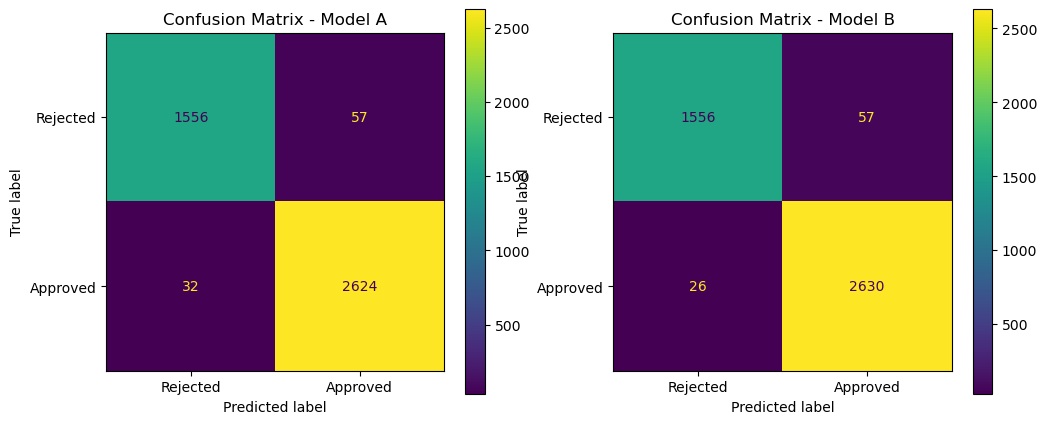

Disparate Impact (Model A): 1.0152
Disparate Impact (Model B): 1.0111

Approval Rate - Model A: 62.80%
Approval Rate - Model B: 62.94%


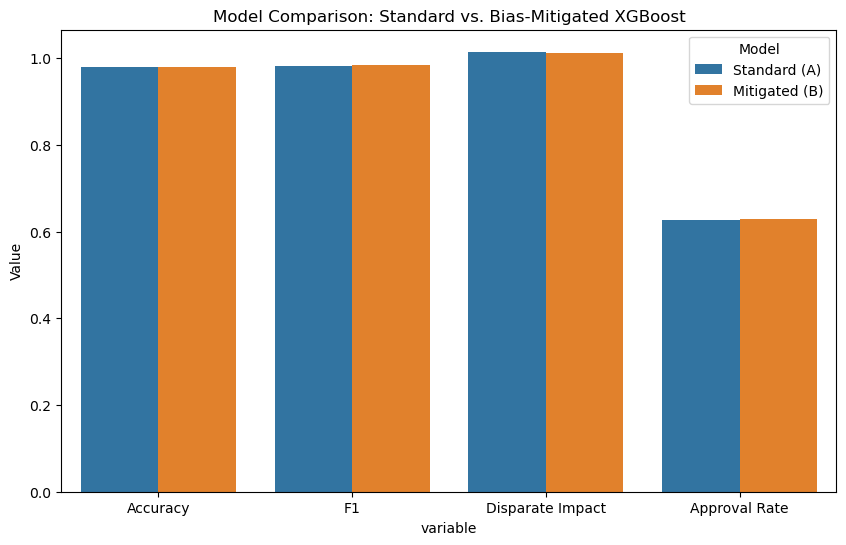

In [9]:
# ===============================
# Loan Approval Bias Mitigation with XGBoost (Kaggle Ready)
# ===============================

# Import libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from scipy.stats import ttest_rel, chi2_contingency
import matplotlib.pyplot as plt
import seaborn as sns

# ===============================
# Load dataset (adjust path if needed in Kaggle)
# ===============================
df = pd.read_csv('loan_approval_dataset.csv')  

# ===============================
# Preprocess data
# ===============================
df = df.applymap(lambda x: x.strip() if isinstance(x, str) else x)

# Encode categorical variables
df['education'] = df['education'].map({'Graduate': 1, 'Not Graduate': 0})
df['self_employed'] = df['self_employed'].map({'Yes': 1, 'No': 0})
y = df['loan_status'].map({'Rejected': 0, 'Approved': 1})

# Drop missing rows if any
df = df.dropna(subset=['education', 'self_employed', 'loan_status'])
y = y.dropna()

# Features
features = [
    'no_of_dependents', 'education', 'self_employed', 'income_annum',
    'loan_amount', 'loan_term', 'cibil_score',
    'residential_assets_value', 'commercial_assets_value',
    'luxury_assets_value', 'bank_asset_value'
]
X = df[features]

print("Dataset shape:", X.shape)
print("Class distribution:\n", y.value_counts())

# ===============================
# Cross-Validation Setup
# ===============================
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# -------------------------------
# Group A: Standard XGBoost
# -------------------------------
model_a = XGBClassifier(n_estimators=100, max_depth=3, learning_rate=0.1, random_state=42)
y_pred_a = cross_val_predict(model_a, X, y, cv=cv)

# -------------------------------
# Group B: Bias-mitigated XGBoost (education reweighting)
# -------------------------------
sample_weights = np.where(X['education'] == 0, 1.2, 1.0)
model_b = XGBClassifier(n_estimators=100, max_depth=3, learning_rate=0.1, random_state=42)
y_pred_b = cross_val_predict(model_b, X, y, cv=cv, fit_params={"sample_weight": sample_weights})

# ===============================
# Metrics Calculation
# ===============================
# Accuracy and F1 (per fold for t-test)
acc_a, acc_b, f1_a, f1_b = [], [], [], []
for train_idx, test_idx in cv.split(X, y):
    Xa, ya = X.iloc[train_idx], y.iloc[train_idx]
    Xb, yb = X.iloc[test_idx], y.iloc[test_idx]

    # Model A
    m_a = model_a.fit(Xa, ya)
    p_a = m_a.predict(Xb)
    acc_a.append(accuracy_score(yb, p_a))
    f1_a.append(f1_score(yb, p_a))

    # Model B
    m_b = model_b.fit(Xa, ya, sample_weight=sample_weights[train_idx])
    p_b = m_b.predict(Xb)
    acc_b.append(accuracy_score(yb, p_b))
    f1_b.append(f1_score(yb, p_b))

print("\nCross-Validation Results:")
print(f"Model A - Accuracy: {np.mean(acc_a):.4f}, F1: {np.mean(f1_a):.4f}")
print(f"Model B - Accuracy: {np.mean(acc_b):.4f}, F1: {np.mean(f1_b):.4f}")

# Paired t-test on accuracy
t_stat, p_val = ttest_rel(acc_a, acc_b)
print(f"T-test Accuracy Difference: t={t_stat:.4f}, p={p_val:.4f}")

# ===============================
# Confusion Matrices
# ===============================
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ConfusionMatrixDisplay(confusion_matrix(y, y_pred_a), display_labels=["Rejected","Approved"]).plot(ax=ax[0], values_format='d')
ax[0].set_title("Confusion Matrix - Model A")

ConfusionMatrixDisplay(confusion_matrix(y, y_pred_b), display_labels=["Rejected","Approved"]).plot(ax=ax[1], values_format='d')
ax[1].set_title("Confusion Matrix - Model B")

plt.show()

# ===============================
# Fairness: Disparate Impact (education group)
# ===============================
di_a = (X[y_pred_a == 1]['education'].mean()) / (X[y_pred_a == 0]['education'].mean())
di_b = (X[y_pred_b == 1]['education'].mean()) / (X[y_pred_b == 0]['education'].mean())

print(f"Disparate Impact (Model A): {di_a:.4f}")
print(f"Disparate Impact (Model B): {di_b:.4f}")

# ===============================
# Approval Rate Monitoring
# ===============================
approval_rate_a = (y_pred_a == 1).mean()
approval_rate_b = (y_pred_b == 1).mean()

print(f"\nApproval Rate - Model A: {approval_rate_a:.2%}")
print(f"Approval Rate - Model B: {approval_rate_b:.2%}")

# Visualization of Metrics
metrics_df = pd.DataFrame({
    'Model': ['Standard (A)', 'Mitigated (B)'],
    'Accuracy': [np.mean(acc_a), np.mean(acc_b)],
    'F1': [np.mean(f1_a), np.mean(f1_b)],
    'Disparate Impact': [di_a, di_b],
    'Approval Rate': [approval_rate_a, approval_rate_b]
})

plt.figure(figsize=(10, 6))
sns.barplot(data=metrics_df.melt(id_vars='Model'), x='variable', y='value', hue='Model')
plt.title('Model Comparison: Standard vs. Bias-Mitigated XGBoost')
plt.ylabel('Value')
plt.show()


In [11]:
import pandas as pd

# Results from your run
results = {
    "Model": ["Standard (A)", "Bias-Mitigated (B)"],
    "Accuracy": [0.9792, 0.9806],
    "F1 Score": [0.9833, 0.9845],
    "Disparate Impact": [1.0152, 1.0111],
    "Approval Rate": ["62.80%", "62.94%"],
    "Statistical Significance": ["-", "p=0.208 (NS)"]
}

# Create DataFrame
report_df = pd.DataFrame(results)

# Display in notebook
print("\nLoan Approval Model Production Report")
display(report_df)

# Save as CSV for sharing with production team
report_df.to_csv("loan_model_production_report.csv", index=False)
print("\nReport saved as 'loan_model_production_report.csv'")



Loan Approval Model Production Report


,Model,Accuracy,F1 Score,Disparate Impact,Approval Rate,Statistical Significance
0,Standard (A),0.9792,0.9833,1.0152,62.80%,-
1,Bias-Mitigated (B),0.9806,0.9845,1.0111,62.94%,p=0.208 (NS)



Report saved as 'loan_model_production_report.csv'
